In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import sys
from scipy.optimize import curve_fit

sys.path.insert(1, '../code')
from featurize_and_fit import Featurizer, Fitter
import plotter
import scalars

%load_ext autoreload
%autoreload 2

## Load data

In [2]:
y_scalar_feature_name='mass_hydro_subhalo_star'

In [3]:
mass_multiplier = 1e10

In [4]:
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
sim_name_50 = 'TNG50-4'
sim_name_50_dark = 'TNG50-4-Dark'
sim_name_100 = 'TNG100-1'
sim_name_100_dark = 'TNG100-1-Dark'
snap_num_str = '099' # z = 0

In [5]:
featurizer_50 = Featurizer(base_dir, sim_name_50, sim_name_50_dark, snap_num_str)
featurizer_50.load_halo_dicts(num_star_particles_min=1, halo_mass_min=10**10.8,
                           halo_mass_min_str='1e10.8', halo_mass_difference_factor=3.0,
                           force_reload=False)
featurizer_50.set_y_labels(y_scalar_feature_name=y_scalar_feature_name)

Halo file ../data/halo_dicts/halo_dicts_TNG50-4_nstarmin1_hmassmin1e10.8_mdifffac3.0.npy exists, loading
1878 halos in matched, selected halo dicts


In [6]:
featurizer_100 = Featurizer(base_dir, sim_name_100, sim_name_100_dark, snap_num_str)
featurizer_100.load_halo_dicts(num_star_particles_min=1, halo_mass_min=10**10.8,
                           halo_mass_min_str='1e10.8', halo_mass_difference_factor=3.0,
                           force_reload=False)
featurizer_100.set_y_labels(y_scalar_feature_name=y_scalar_feature_name)

Halo file ../data/halo_dicts/halo_dicts_TNG100-1_nstarmin1_hmassmin1e10.8_mdifffac3.0.npy exists, loading
20098 halos in matched, selected halo dicts


In [7]:
# Inputs to SHMR broken power law:
# N: the normalization of the SHM ratio 
# M1: a characteristic mass 
# β and γ: indicate the behavior of m/M at the low and high-mass ends
def broken_power_law_byeye(M200, N=0.01, M1=1e12/mass_multiplier, beta=1.5, gamma=0.4):
    return M200*2*N/((M200/M1)**(-beta) + (M200/M1)**gamma)

In [8]:
# defaults are best-fit values from Engler+2020
def broken_power_law_engler(logMdyn, N=0.0258, logM1=11.70, beta=28.6, gamma=10.4):
    return 10**logMdyn * 2*N/((logMdyn/logM1)**(-beta) + (logMdyn/logM1)**gamma)

In [9]:
M = np.logspace(10, 14.8, 100)
m_byeye = broken_power_law_byeye(M/mass_multiplier)
m_engler = broken_power_law_engler(np.log10(M))

In [10]:
m200_50 = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer_50.halo_dicts])
m_stellar_50 = featurizer_50.y_scalar

In [11]:
m200_100 = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer_100.halo_dicts])
m_stellar_100 = featurizer_100.y_scalar

Text(0, 0.5, '$M_\\mathrm{galaxy}$')

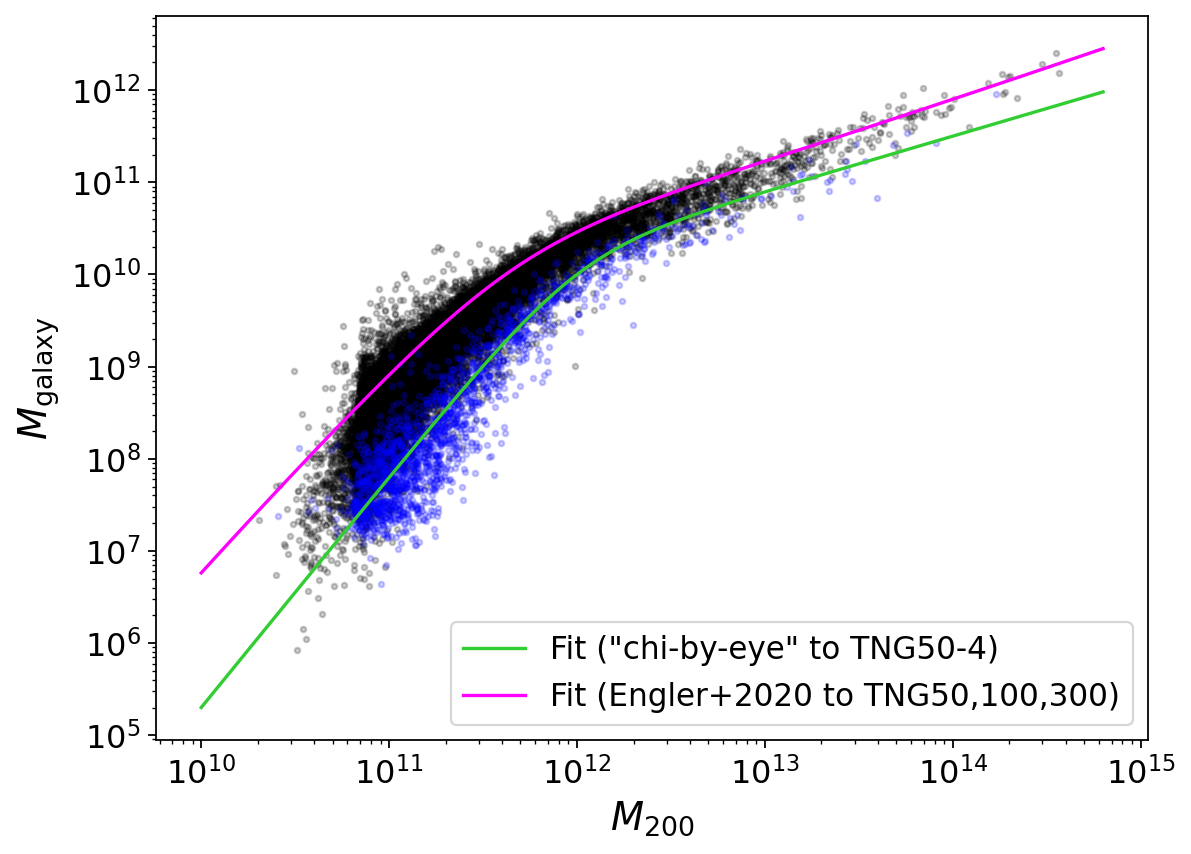

In [12]:
plt.figure(figsize=(8,6))

plt.scatter(m200_100*mass_multiplier, m_stellar_100*mass_multiplier, c='k', alpha=0.2, s=6)
plt.scatter(m200_50*mass_multiplier, m_stellar_50*mass_multiplier, c='b', alpha=0.2, s=6)

plt.plot(M, m_byeye*mass_multiplier, color='limegreen', label='Fit ("chi-by-eye" to TNG50-4)')
plt.plot(M, m_engler, color='magenta', label='Fit (Engler+2020 to TNG50,100,300)')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)

plt.xlabel(r'$M_{200}$')
plt.ylabel(r'$M_\mathrm{galaxy}$')

Note: Engler+2020 actually uses Mdyn, dynamical mass! Can't figure out how to get.

Note: This is for just the matched subhalos, so it will be a subset of all, but it should only include centrals.

## TNG50 Power law fit

In [45]:
def broken_power_law(M200, N, M1, beta, gamma):
    return M200 * 2*N/((M200/M1)**(-beta) + (M200/M1)**gamma)

Uncertainties from Genel+2019 Figure 8, upper right panel:

In [46]:
def get_uncertainties_genel2019(sim_name, masses):

    logmstellar_bins = np.linspace(8.5, 11, 6)
    logmstellar_bins = np.array([5] + list(logmstellar_bins) + [13])
    # added estimates on either end
    stdev_dict = {'TNG50-4': np.array([0.4, 0.28, 0.23, 0.12, 0.05, 0.04, 0.04]), # epsilon=4, similar to tng50-4
                  'TNG100-1': np.array([0.15, 0.08, 0.06, 0.04, 0.03, 0.04, 0.04]), # epsilon=1, similar to tng100-1
                 }

    logyscalar = np.log10(masses*mass_multiplier)
    idxs_mbins = np.digitize(logyscalar, logmstellar_bins)

    stdevs = stdev_dict[sim_name][idxs_mbins-1]
    uncertainties = stdevs * masses * np.log(10.0)
    # hack to deal with 0-stellar-mass objects
    uncertainties[uncertainties==0] = stdev_dict[sim_name][0] * 10**logmstellar_bins[0]/mass_multiplier
    return uncertainties

In [47]:
sim_name = 'TNG50-4'
uncertainties_genel2019_50 = get_uncertainties_genel2019(sim_name, m_stellar_50)

In [48]:
p0 = [0.01, 1e12/mass_multiplier, 1.5, 0.4]
bounds = [[0]*len(p0), [np.inf]*len(p0)]
print(bounds)
popt, _ = curve_fit(broken_power_law, m200_50, m_stellar_50, sigma=uncertainties_genel2019_50, bounds=bounds, p0=p0)
popt

[[0, 0, 0, 0], [inf, inf, inf, inf]]


array([6.97216467e-03, 9.35451562e+01, 2.10888806e+00, 3.81703760e-01])

Text(0, 0.5, '$M_\\mathrm{galaxy}$')

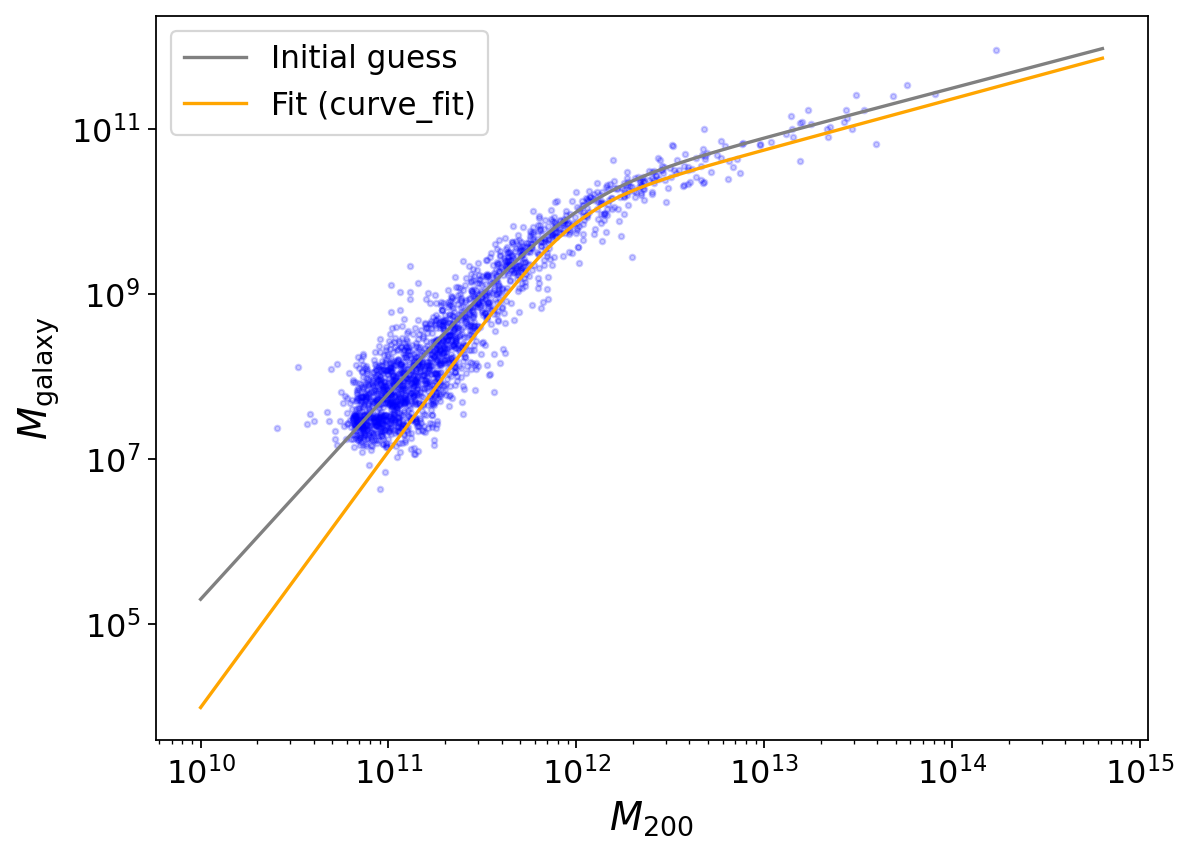

In [49]:
plt.figure(figsize=(8,6))

plt.scatter(m200_50*mass_multiplier, m_stellar_50*mass_multiplier, c='b', alpha=0.2, s=6)

plt.plot(M, broken_power_law(M/mass_multiplier, *p0)*mass_multiplier, color='grey', label='Initial guess')
plt.plot(M, broken_power_law(M/mass_multiplier, *popt)*mass_multiplier, color='orange', label='Fit (curve_fit)')


plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)

plt.xlabel(r'$M_{200}$')
plt.ylabel(r'$M_\mathrm{galaxy}$')

## TNG100

In [54]:
sim_name = 'TNG100-1'
uncertainties_genel2019_100 = get_uncertainties_genel2019(sim_name, m_stellar_100)

In [55]:
p0 = [0.01, 1e12/mass_multiplier, 1.5, 0.4]
bounds = [[0]*len(p0), [np.inf]*len(p0)]
print(bounds)
popt, _ = curve_fit(broken_power_law, m200_100, m_stellar_100, sigma=uncertainties_genel2019_100, bounds=bounds, p0=p0)
popt

[[0, 0, 0, 0], [inf, inf, inf, inf]]


array([9.76858661e-03, 2.96577391e+01, 2.21001810e+00, 1.75461247e-01])

Text(0, 0.5, '$M_\\mathrm{galaxy}$')

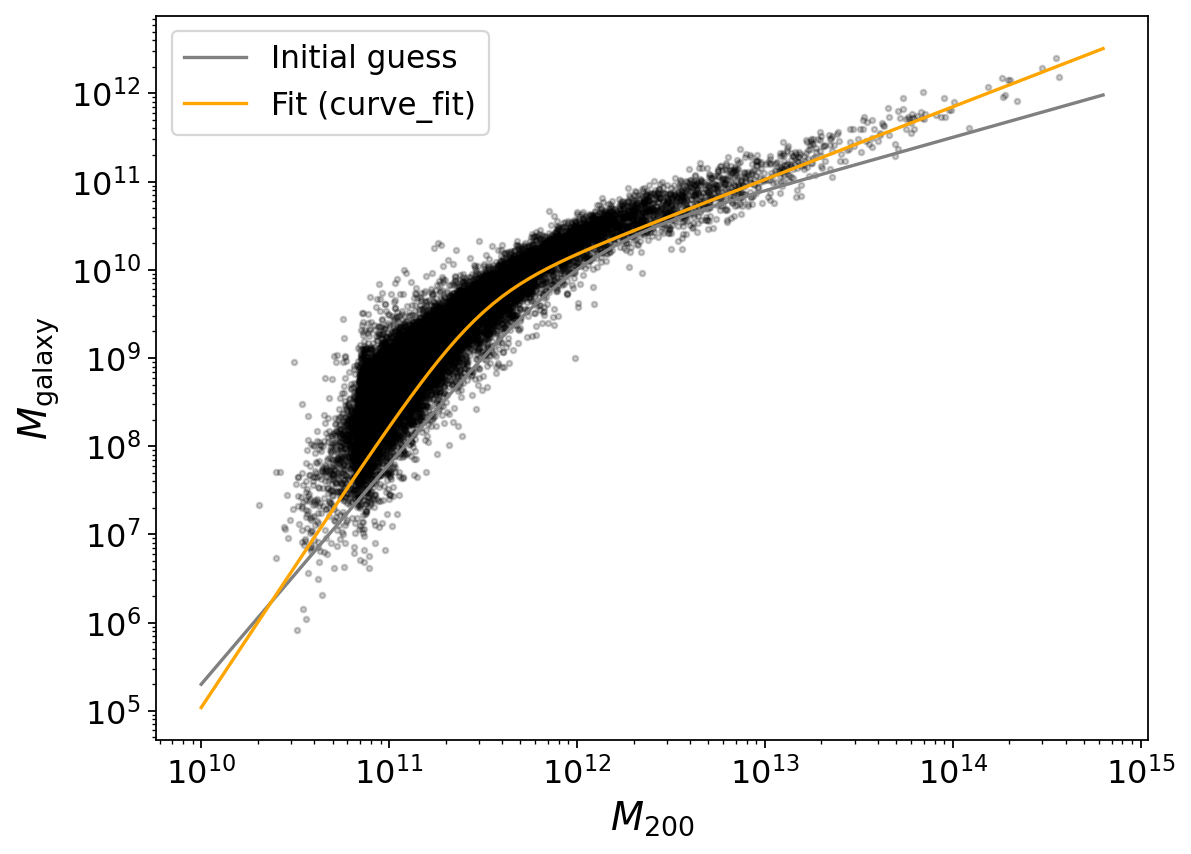

In [56]:
plt.figure(figsize=(8,6))

plt.scatter(m200_100*mass_multiplier, m_stellar_100*mass_multiplier, c='k', alpha=0.2, s=6)

plt.plot(M, broken_power_law(M/mass_multiplier, *p0)*mass_multiplier, color='grey', label='Initial guess')
plt.plot(M, broken_power_law(M/mass_multiplier, *popt)*mass_multiplier, color='orange', label='Fit (curve_fit)')


plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)

plt.xlabel(r'$M_{200}$')
plt.ylabel(r'$M_\mathrm{galaxy}$')